<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
$\beta\beta0\nu$ Reco </p><br>

## Documents $\beta\beta0\nu$ reconstruction functions in NextFlex

In [80]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### General

In [81]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [82]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [83]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [85]:
idx = pd.IndexSlice

#### IC

In [86]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


#### TICs

In [87]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.system_of_units import *

#### NetFlex

In [88]:
from nextflex.core import Setup

In [125]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits
from nextflex.mctrue_functions import get_true_extremes
from nextflex.mctrue_functions import get_particle_ids_from_mchits
from nextflex.mctrue_functions import get_hit_ids_from_mchits

In [90]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy

### Input data

In [91]:
FDATA = os.environ['FLEXDATA']

### test file

In [134]:
testFilebb      = os.path.join(FDATA,"testData",
                            'FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.0.next.h5')
testFile1e      = os.path.join(FDATA,"testData",
                            'FLEX100_M6_O6.e-.ACTIVE.1000.next.h5')


### Monte Carlo True information

#### McHits
- The McHits object is a table of "McTrue" hits (x,y,z,time, energy, label) indexed by event_id, particle_id and hit_id.

##### For a bbonu file

In [135]:
mcHits_bb = get_mc_hits(testFilebb)
mcHits_bb

<McHits>
        Columns = ('x', 'y', 'z', 'time', 'energy', 'label')
        Indexes = ('event_id', 'particle_id', 'hit_id')
        

In [137]:
mcHits_bb.df

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
3        83631883    77      361.853577   76.278801  991.085022  0.180530   
                     78      361.854279   76.278984  991.085205  0.180554   
                     79      361.854858   76.279205  991.085327  0.180574   
                     80      361.854950   76.279205  991.085815  0.180591   
                     81      361.854919   76.279099  991.086670  0.180629   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
3        83631883    77      0.000109  ACTIVE  
                     78      0.000363  ACTIVE  
                     79      0.000117  ACTIVE  
                     80      0.000899  ACTIVE  
                     81      0.001552  ACTIVE  

[2319 rows x 6 columns]

##### The event list is accesible via method event_list() 

In [194]:
mcHits_bb.event_list()

array([0, 1, 2, 3])

##### And the subyacent DataFrame via the attribute df

In [195]:
mcbb = mcHits_bb.df

##### or a 1e file

In [140]:
mcHits_1e = get_mc_hits(testFile1e)
mcHits_1e

<McHits>
        Columns = ('x', 'y', 'z', 'time', 'energy', 'label')
        Indexes = ('event_id', 'particle_id', 'hit_id')
        

In [141]:
mcHits_1e.df

x           y           z      time  \
event_id particle_id hit_id                                                 
5000     1           0      -459.471741   35.686749  680.406738  0.003376   
                     1      -460.011810   36.272388  679.806702  0.006753   
                     2      -460.630341   36.872669  679.305908  0.010129   
                     3      -461.301666   37.448700  678.840576  0.013514   
                     4      -461.951935   38.031681  678.373108  0.016870   
...                                 ...         ...         ...       ...   
5004     107284662   105    -108.350067  197.361862  823.132751  0.361198   
                     106    -108.351059  197.362000  823.133057  0.361227   
                     107    -108.352043  197.362106  823.133240  0.361256   
                     108    -108.353806  197.362274  823.133545  0.361308   
                     109    -108.353615  197.362976  823.132996  0.361349   

                               energy   label  
event_id particle_id hit_id                    
5000     1           0       0.009271  ACTIVE  
                     1       0.006503  ACTIVE  
                     2       0.003626  ACTIVE  
                     3       0.007412  ACTIVE  
                     4       0.009619  ACTIVE  
...                               ...     ...  
5004     107284662   105     0.000453  ACTIVE  
                     106     0.000188  ACTIVE  
                     107     0.000017  ACTIVE  
                     108     0.001673  ACTIVE  
                     109     0.001821  ACTIVE  

[2226 rows x 6 columns]

In [142]:
mcHits_1e.event_list()

array([5000, 5001, 5002, 5003, 5004])

In [143]:
mc1e = mcHits_1e.df

#### True extremes
- The definition of true extreme depends on whether the event is bb0nu or 1e.
    - For bbonu, the extremes are the last hit of each electron (particle 1 and particle 2)
    - For 1e the extremes are first and last hit of particle 1.
- Since hits are time-ordered one can use time to define what is first and last hits. 

##### The case of bb0nu

In [163]:
mcbb_evt = mcbb.loc[(slice(0,0), slice(None,None), slice(None,None)), :]

In [164]:
mcbb_evt 

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
         105872151   1      -285.659393 -247.800232  719.528992  0.097352   
         105872152   0      -285.658569 -247.798447  719.528198  0.097295   
         105872153   0      -285.658447 -247.798492  719.528198  0.097279   
         105872154   0      -285.658417 -247.798584  719.528198  0.097295   
         105872155   0      -285.658478 -247.798523  719.528259  0.097302   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
         105872151   1       0.002498  ACTIVE  
         105872152   0       0.000473  ACTIVE  
         105872153   0       0.000068  ACTIVE  
         105872154   0       0.000047  ACTIVE  
         105872155   0       0.000021  ACTIVE  

[549 rows x 6 columns]

##### Select p1

In [182]:
mcbb_evt_p1 = mcbb.loc[(slice(0,0), slice(1,1), slice(None,None)), :]
mcbb_evt_p1

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
                     167    -273.206543 -255.572403  724.871521  0.348812   
                     168    -273.206848 -255.572388  724.871704  0.348827   
                     169    -273.207123 -255.572449  724.871887  0.348840   
                     170    -273.207031 -255.572357  724.871948  0.348848   
                     171    -273.207062 -255.572342  724.871460  0.348872   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
                     167     0.000054  ACTIVE  
                     168     0.000060  ACTIVE  
                     169     0.000604  ACTIVE  
                     170     0.000030  ACTIVE  
                     171     0.001073  ACTIVE  

[172 rows x 6 columns]

In [183]:
times_bb_p1 = mcbb_evt_p1.time

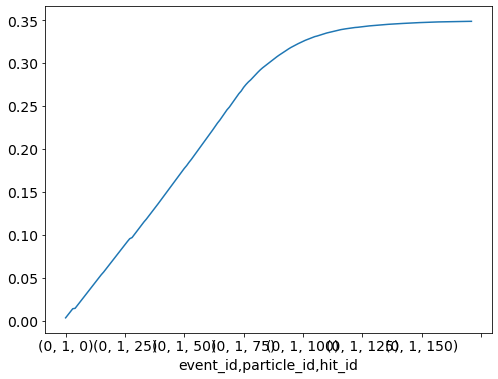

In [196]:
_ = times_bb_p1.plot()

##### Last hit of p1 is the hit with larger time

In [197]:
np.max(times_bb_p1)

0.34887227

##### Particle 2

In [185]:
mcbb_evt_p2 = mcbb.loc[(slice(0,0), slice(2,2), slice(None,None)), :]
mcbb_evt_p2

x           y           z      time  \
event_id particle_id hit_id                                                 
0        2           0      -269.774200 -241.066391  726.139587  0.003456   
                     1      -269.620819 -241.162506  727.120544  0.006907   
                     2      -269.476990 -241.136002  728.105835  0.010353   
                     3      -269.321198 -241.076401  729.089966  0.013808   
                     4      -268.974609 -240.957947  730.017883  0.017262   
...                                 ...         ...         ...       ...   
                     232    -261.045044 -230.865311  792.874207  0.523255   
                     233    -261.040497 -230.861237  792.875977  0.523395   
                     234    -261.040619 -230.861526  792.875183  0.523420   
                     235    -261.040161 -230.861877  792.874268  0.523449   
                     236    -261.039703 -230.863617  792.874023  0.523512   

                               energy   label  
event_id particle_id hit_id                    
0        2           0       0.004999  ACTIVE  
                     1       0.005551  ACTIVE  
                     2       0.007877  ACTIVE  
                     3       0.005921  ACTIVE  
                     4       0.021864  ACTIVE  
...                               ...     ...  
                     232     0.000029  ACTIVE  
                     233     0.002607  ACTIVE  
                     234     0.000031  ACTIVE  
                     235     0.000735  ACTIVE  
                     236     0.002869  ACTIVE  

[237 rows x 6 columns]

In [186]:
times_bb_p2 = mcbb_evt_p2.time

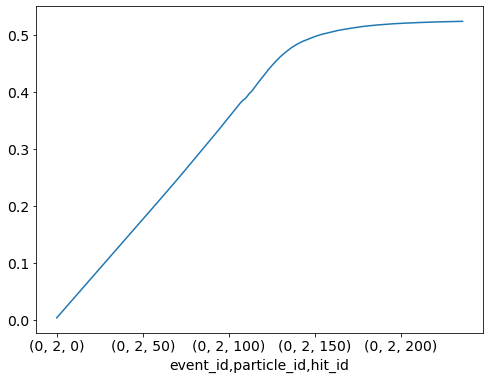

In [187]:
times_bb_p2.plot()

##### Last hit of particle 2

In [198]:
np.max(times_bb_p2)

0.52351236

##### Single electron

In [168]:
mc1e_evt = mc1e.loc[(slice(5000,5000), slice(None,None), slice(None,None)), :]

In [169]:
mc1e_evt

x          y           z      time  \
event_id particle_id hit_id                                                
5000     1           0      -459.471741  35.686749  680.406738  0.003376   
                     1      -460.011810  36.272388  679.806702  0.006753   
                     2      -460.630341  36.872669  679.305908  0.010129   
                     3      -461.301666  37.448700  678.840576  0.013514   
                     4      -461.951935  38.031681  678.373108  0.016870   
...                                 ...        ...         ...       ...   
                     75     -483.115021  92.394600  661.419922  0.255769   
                     76     -483.195190  92.482056  661.471008  0.256210   
                     77     -483.206512  92.495033  661.478333  0.256274   
                     78     -483.223602  92.511650  661.490112  0.256365   
                     79     -483.224091  92.512100  661.490417  0.256367   

                               energy   label  
event_id particle_id hit_id                    
5000     1           0       0.009271  ACTIVE  
                     1       0.006503  ACTIVE  
                     2       0.003626  ACTIVE  
                     3       0.007412  ACTIVE  
                     4       0.009619  ACTIVE  
...                               ...     ...  
                     75      0.002484  ACTIVE  
                     76      0.000117  ACTIVE  
                     77      0.000056  ACTIVE  
                     78      0.000129  ACTIVE  
                     79      0.000006  ACTIVE  

[80 rows x 6 columns]

In [170]:
times1e = mc1e_evt.time

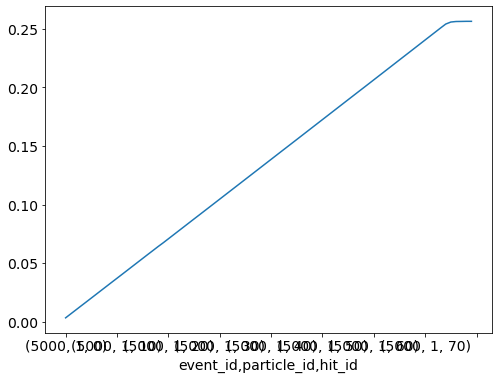

In [171]:
times1e.plot()

##### First and last hit

In [172]:
np.min(times1e)

0.0033755803

In [173]:
np.max(times1e)

0.25636715

##### Get true extremes from function (bb)

In [200]:
tebb = get_true_extremes(mcHits_bb, event_id= 0, event_type = "bb0nu").df

In [201]:
tebb

,x,y,z,time,energy,label
0,-273.207062,-255.572342,724.871460,0.348872,0.001073,ACTIVE
1,-261.039703,-230.863617,792.874023,0.523512,0.002869,ACTIVE


In [202]:
tebb.time

0    0.348872
1    0.523512
Name: time, dtype: float32

In [203]:
np.allclose(tebb.time[0], np.max(times_bb_p1))

True

In [204]:
np.allclose(tebb.time[1], np.max(times_bb_p2))

True

##### For 1e

In [205]:
te1e = get_true_extremes(mcHits_1e, event_id= 5000, event_type = "1e").df

In [206]:
te1e

,x,y,z,time,energy,label
0,-459.471741,35.686749,680.406738,0.003376,0.009271,ACTIVE
1,-483.224091,92.512100,661.490417,0.256367,0.000006,ACTIVE


In [207]:
te1e.time

0    0.003376
1    0.256367
Name: time, dtype: float32

In [208]:
np.allclose(te1e.time[0], np.min(times1e))

True

In [209]:
np.allclose(te1e.time[1], np.max(times1e))

True

#### primary hits

In [111]:
mcphits = get_event_hits_from_mchits(mcHits, event_id=604, particle_type='primary')

In [112]:
mcphits.df.energy.sum()

2.2719684

In [113]:
mcphits

<EventHits>
        event number = 604
        Columns = ('x', 'y', 'z', 'energy')
        

In [114]:
mcphits.df

,x,y,z,energy
0,86.537773,52.202663,241.220688,0.010750
1,87.280510,51.688950,241.643097,0.002699
2,88.054764,51.160336,241.982452,0.010277
3,88.838638,50.606918,242.260422,0.005601
4,89.666405,50.082752,242.456207,0.008392
...,...,...,...,...
427,80.669830,68.617065,252.284607,0.000026
428,80.671585,68.616425,252.285172,0.000771
429,80.672852,68.615799,252.284927,0.000352
430,80.673820,68.614799,252.284866,0.002466


In [121]:
mc = mcphits.df

In [115]:
mcphits.df.energy.sum()

2.2719684

In [120]:
get_true_extremes(mcphits, event_id= 604, event_type = "bb0nu")

604 1
slice(604, 604, None)
slice(604, 604, None)
slice(1, 1, None)
slice(None, None, None)


TypeError: unhashable type: 'slice'

#### all hits

In [30]:
mchits = get_event_hits_from_mchits(mcHits, event_id=632, particle_type='all')

In [31]:
mchits

<EventHits>
        event number = 632
        Columns = ('x', 'y', 'z', 'energy')
        

In [32]:
mchits.df.energy.sum()

0.24648362

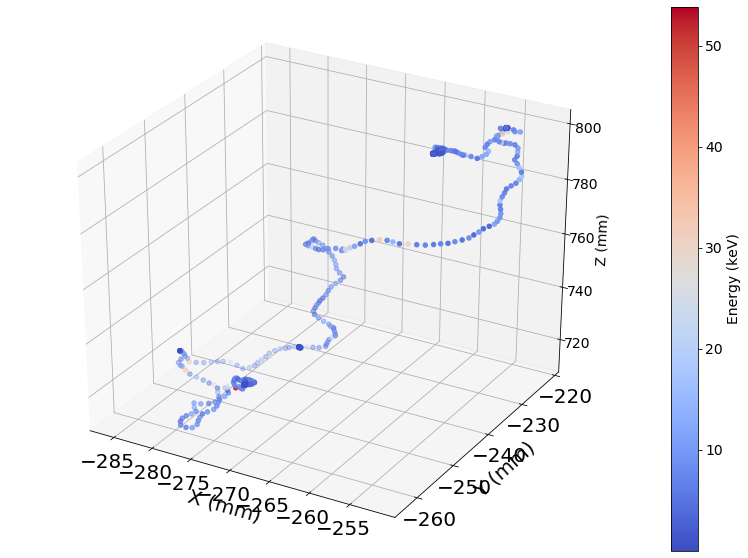

In [24]:
plot_hits3d(mchits.df, autorange = True, figsize   = (14,10))

### Voxelize

- To voxelize a set of hits (defined by x,y,z,energy), one needs to do the following:
    - Define voxels (e.g, cubic volumes) by dividing the space in 3d bins 
    - Group all the hits contained in the voxel. 

- The voxel has fields (x,y,z,energy, nhits), where nhits is the number of hits used to form the track and
the (x,y,z) of the voxels are the barycenters of the hits: e.g, 

$x_v = \frac{\sum x_i e_i}{\sum e_i}$, where:

$x_v=(x,y,z)$ of the voxel

$x_i=(x,y,z)$ of each hit in the voxel, $e_i$ is the energy of each hit in the voxel

The energy of the voxel is the sum of the energies of the hits, $e_v = \sum e_i$

***
def voxelize_hits(hits     : EventHits,
                  bin_size : int,
                  baryc    : bool = True)->VoxelHits:
                  
    """
    Takes a EventHits objects wit fields (x,y,z,energy)
    voxelize the data in cubic voxels of size bin_size and return
    a VoxelHits object, which includes the field nhits (number of hits)
    used to form the voxel. If the field barycenter is True,
    compute the (x, y, z) position of the voxel as the baryc
    of the hits, otherwise as the mean of the positions of the hits.

    """
***

#### Using barycenter to define the hit position

In [25]:
vt12 = voxelize_hits(mchits, bin_size = 1, baryc = True)
vt12df = vt12.df

In [26]:
vt12df.head()

,x,y,z,energy,nhits
0,-285.018433,-248.666336,721.137085,0.009695,1.0
1,-285.166626,-247.589310,718.438232,0.005763,1.0
2,-285.651343,-247.766070,719.511444,0.006362,8.0
3,-285.326538,-248.255112,720.280457,0.003507,1.0
4,-283.654358,-251.966583,721.192932,0.006694,1.0


In [28]:
len(vt12df)

204

#### Using hit average as positions

In [183]:
gt12df = voxelize_hits(mchits, bin_size = 1, baryc = False).df

In [184]:
gt12df.head()

,x,y,z,energy,nhits
0,-285.018433,-248.666336,721.137085,0.009695,1.0
1,-285.166626,-247.589310,718.438232,0.005763,1.0
2,-285.656677,-247.790344,719.524048,0.006362,8.0
3,-285.326538,-248.255112,720.280457,0.003507,1.0
4,-283.654358,-251.966583,721.192932,0.006694,1.0


The outcome is pretty close between both methods:

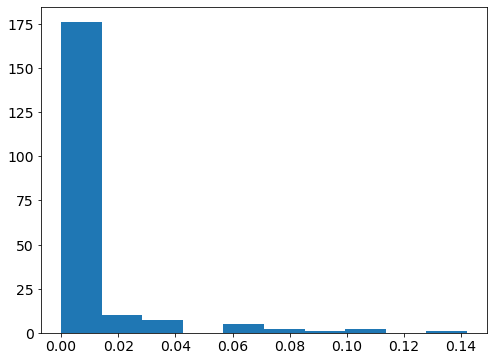

In [185]:
out = plt.hist(np.abs(gt12df.x.values - vt12df.x.values))

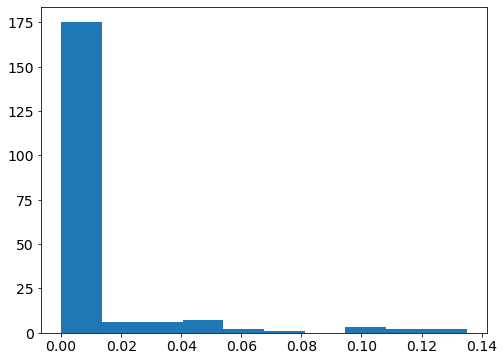

In [186]:
out = plt.hist(np.abs(gt12df.y.values - vt12df.y.values))

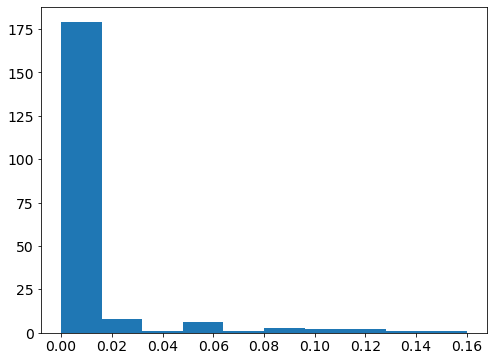

In [187]:
out = plt.hist(np.abs(gt12df.z.values - vt12df.z.values))

In [188]:
np.allclose(gt12df.nhits.values, vt12df.nhits.values)

True

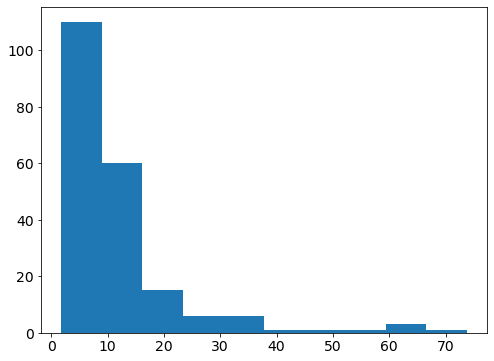

In [189]:
out = plt.hist(vt12df.energy/keV)

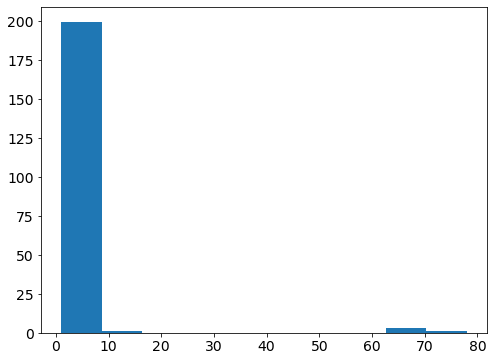

In [190]:
out = plt.hist(vt12df.nhits)

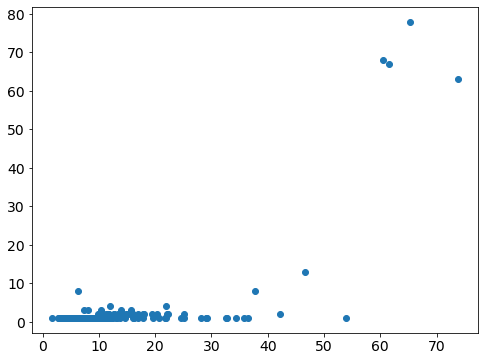

In [191]:
plt.scatter(vt12df.energy/keV, vt12df.nhits )

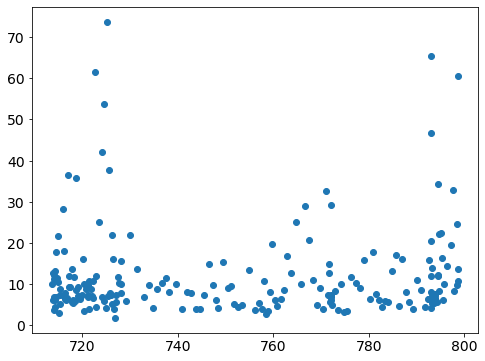

In [192]:
plt.scatter(vt12df.z, vt12df.energy/keV)

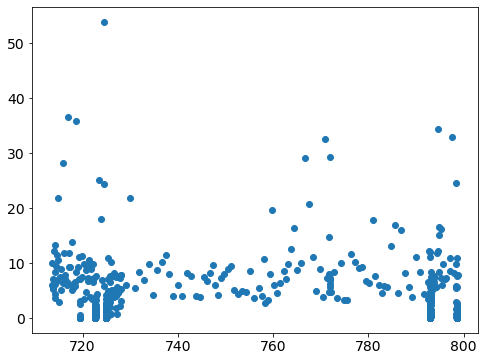

In [193]:
plt.scatter(mchits.df.z, mchits.df.energy/keV)

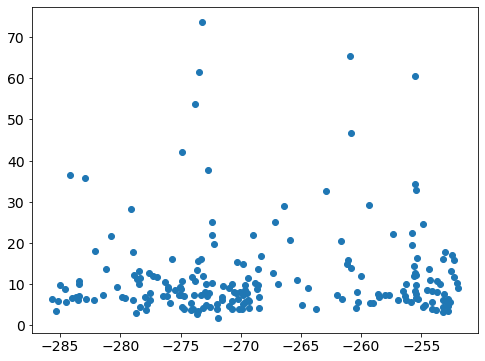

In [194]:
plt.scatter(vt12df.x, vt12df.energy/keV)

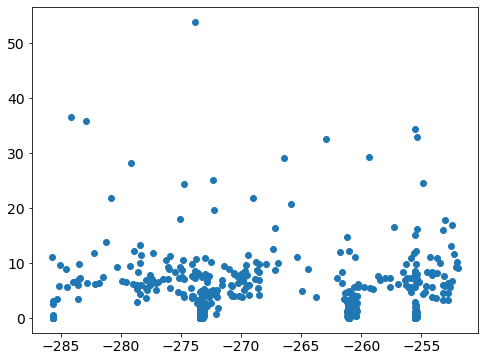

In [195]:
plt.scatter(mchits.df.x, mchits.df.energy/keV)

#### Draw hits and voxelized hits

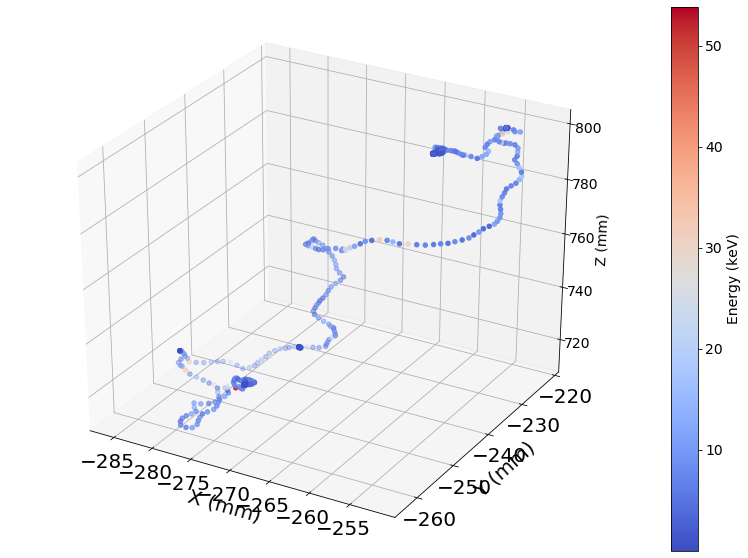

In [196]:
plot_hits3d(mchits.df, autorange = True, figsize   = (14,10))

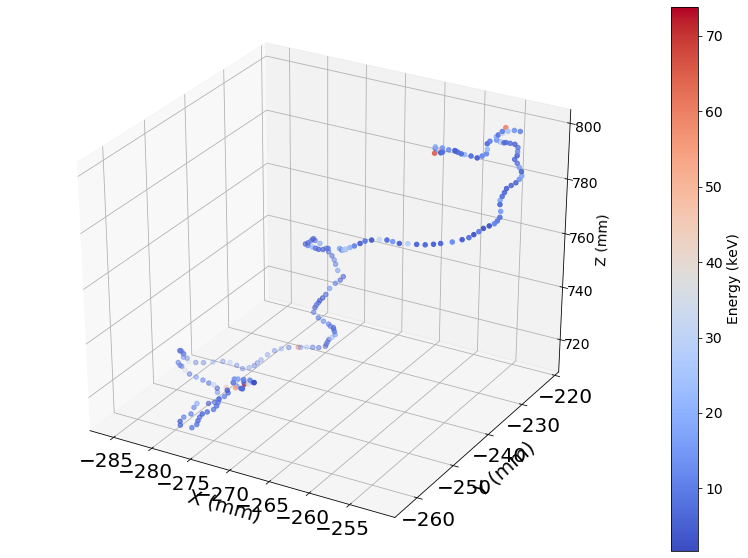

In [197]:
plot_hits3d(vt12df, autorange = True, figsize   = (14,10))

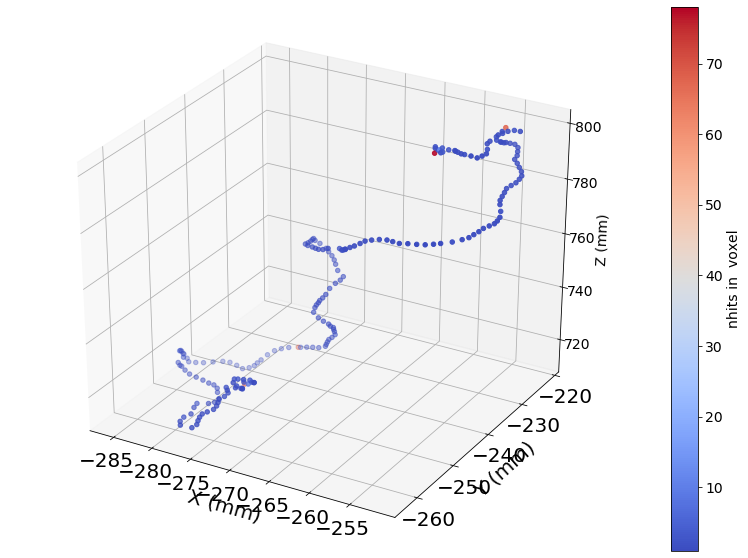

In [198]:
plot_hits3d(vt12df, autorange = True, weight='nhits', figsize   = (14,10))

## Organise hits into a track

- The next step is to organise the voxels into a track. One way to do this is to define a graph.
***

def make_track_graphs(voxels : List[Voxel], contiguity : float)->List[nx.Graph]:

    """
    Make "graph-tracks" (gtracks) using networkx:

    1. Define a graph such that each voxel is a node and there is a link
    (or edge) between each pair of nodes which are at a distance smaller
    than defined by contiguity.

    2. Return a list of graphs made with connected components. Each connected
    component graph is made of a set of connected nodes (eg. nodes which are
    at a distance smaller than contiguity)

    """
***

- The function above uses **networkx** which needs a list of voxels: ((x0,y0,z0,e0), (x1,y1,z1,e1)...))
- Therefore is convenient to define a Voxel type as a simple pseudonim for a List of Tuples of float

***
Voxel = TypeVar('Voxel', Tuple[float], np.array)  # define voxel as type
***

- And a utility function that produces the voxels from the hits

***
def get_voxels_as_list(voxeldf : DataFrame)->List[Voxel]:

    """
    Return the voxels as a list of tuples with the coordinates
    (this is needed for networkx)

    """

def position(v : Voxel)->np.array:

    """
    Return the position of a voxel as a numpy array

    """

def distance(va : Voxel, vb : Voxel)->float:

    """
    Return the distance between two voxels

    """

def voxel_distances(voxels : List[Voxel])->Tuple[np.array]:

    """
    Return a numpy array with the distance (inclusive) between any pair
    of voxels, and another array with the minimum distance between a
    voxel and all the others.

    """

def voxel_distance_pairs(voxels : List[Voxel])->Tuple[np.array]:

    """
    Return a numpy array with the distance (inclusive) between any pair
    of voxels, use a list conprehension.

    """
***

#### Compute inclusive distance between any pair of voxels and minimum distance between a voxel and any other voxel

In [29]:
voxels = get_voxels_as_list(vt12)

In [30]:
minimum_d, inclusive_d = voxel_distances(voxels)

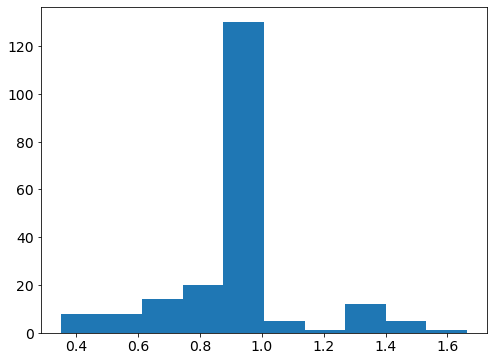

In [31]:
out = plt.hist(minimum_d)

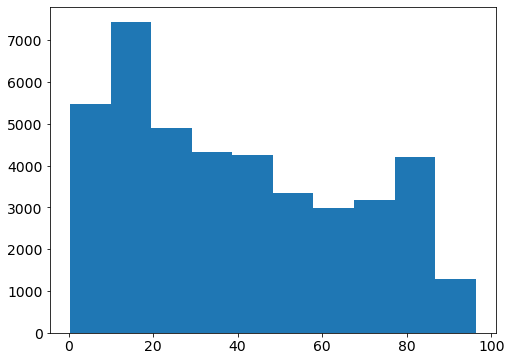

In [202]:
out = plt.hist(inclusive_d)

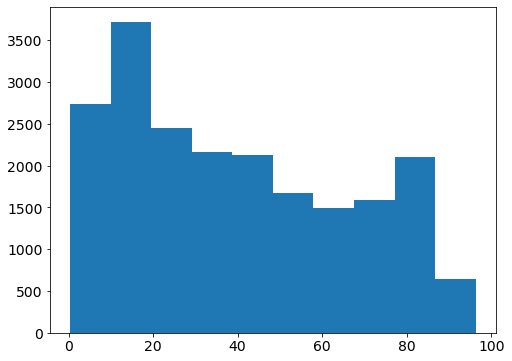

In [203]:
out = plt.hist(voxel_distance_pairs(voxels))

### Define gtracks (graph tracks)

***
def make_track_graphs(voxels : List[Voxel], contiguity : float)->List[nx.Graph]:

    """
    Make "graph-tracks" (gtracks) using networkx:

    1. Define a graph such that each voxel is a node and there is a link
    (or edge) between each pair of nodes which are at a distance smaller
    than defined by contiguity. 

    2. Return a list of graphs made with connected components. Each connected
    component graph is made of a set of connected nodes (eg. nodes which are 
    at a distance smaller than contiguity)

    """
***

#### First example. Take a large value of contiguity (10 mm)

In [204]:
contiguity = 2
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 2 is 1


In [205]:
gtv = gtrack_voxels(gtracks[0], event_id=0)
gtv

<VoxelHits>
        event number = 0
        Columns = ('x', 'y', 'z', 'energy', 'nhits')
        

In [206]:
gtvdf = gtv.df

In [207]:
gtvdf.head()

,x,y,z,energy,nhits
0,-285.018433,-248.666336,721.137085,0.009695,1.0
1,-285.166626,-247.589310,718.438232,0.005763,1.0
2,-285.651343,-247.766070,719.511444,0.006362,8.0
3,-285.326538,-248.255112,720.280457,0.003507,1.0
4,-283.654358,-251.966583,721.192932,0.006694,1.0


In [208]:
vt12df.head()

,x,y,z,energy,nhits
0,-285.018433,-248.666336,721.137085,0.009695,1.0
1,-285.166626,-247.589310,718.438232,0.005763,1.0
2,-285.651343,-247.766070,719.511444,0.006362,8.0
3,-285.326538,-248.255112,720.280457,0.003507,1.0
4,-283.654358,-251.966583,721.192932,0.006694,1.0


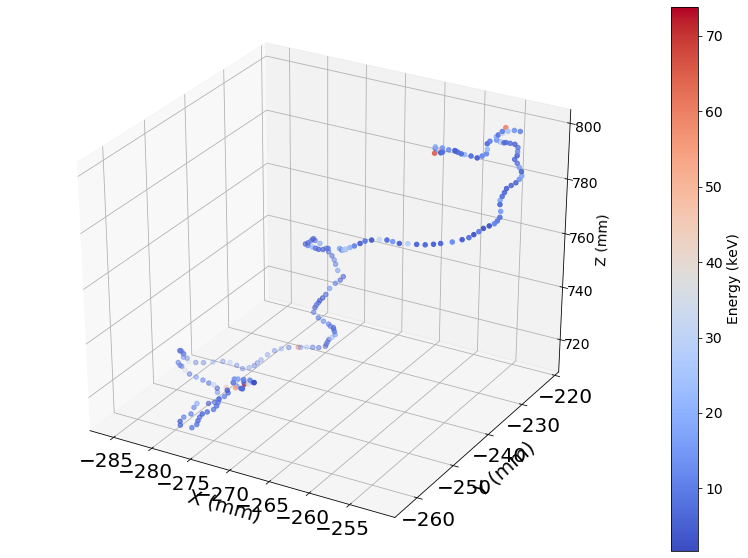

In [209]:
plot_hits3d(gtvdf, autorange = True, figsize   = (14,10))

#### Second example: smallish bin, produce extra tracks

In [210]:
contiguity = 1
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 1 is 46


In [211]:
def number_of_voxels(gtracks):
    gtvs = [gtrack_voxels(gtracks[i], event_id=0).df for i in range(len(gtracks))]
    lgtvs =[len(gtv) for gtv in gtvs]
    return lgtvs

In [213]:
contiguity = 2
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')
number_of_voxels(gtracks)

number of tracks for contiguity of 2 is 1


[204]

In [214]:
gtrack = gtracks[0]

In [215]:
gtv = gtrack_voxels(gtracks[0], event_id=0)

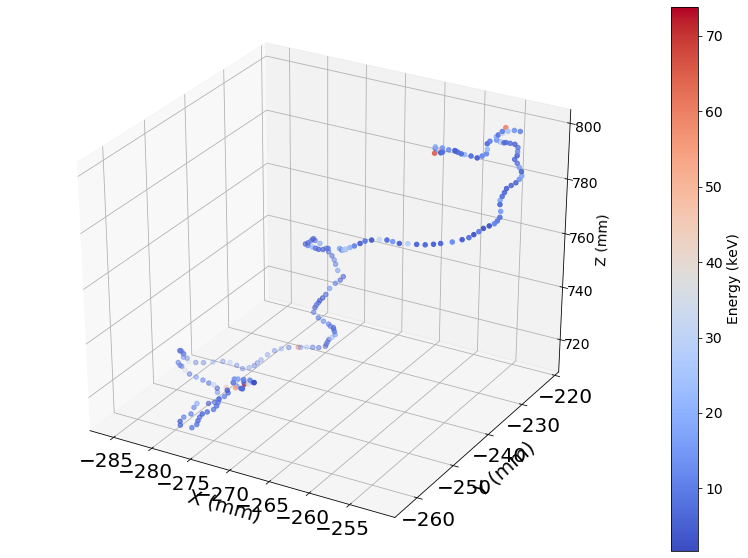

In [216]:
plot_hits3d(gtv.df, autorange = True, figsize   = (14,10))

### Create a GTrack object
- A gtrack takes a graph track and computes the extrema and track length. 

***

@dataclass

class GTrack:

    """
    A graph-track
    gt       : a nx Graph representing the track
    event_id : event number
    ea       : extreme "a"
    eb       : extreme "b"
    length   : track length 
    """
    gt       : nx.Graph 
    # rb       : float # blob radius 
    event_id : int
        
    def __post_init__(self):
        self.extrema = {}
        self.voxels     = get_voxels_as_list(gtrack_voxels(self.gt, self.event_id)) 
        self.voxels_df  = pd.DataFrame(self.voxels, columns =['x', 'y', 'z', 'energy', 'nhits'])
        self.distances  = shortest_paths(self.gt)
        e1, e2, self.length = find_extrema_and_length_from_dict(self.distances) #extrema 1 and 2
        self.extrema['e1'] = e1
        self.extrema['e2'] = e2
    

def voxels_in_blob(gt : GTrack, rb : float, extreme : str ='e1')->VoxelHits:

    """
    Return the a VoxelHits object with the voxels contained in a blob
    of radius rb around the extreme.
    
    """

def blob_energy(gt : GTrack, rb : float, extreme : str ='e1', unit=keV)->float:

    """
    Return the total energy contained in a blob of radius rb around
    the extreme.

    """

***

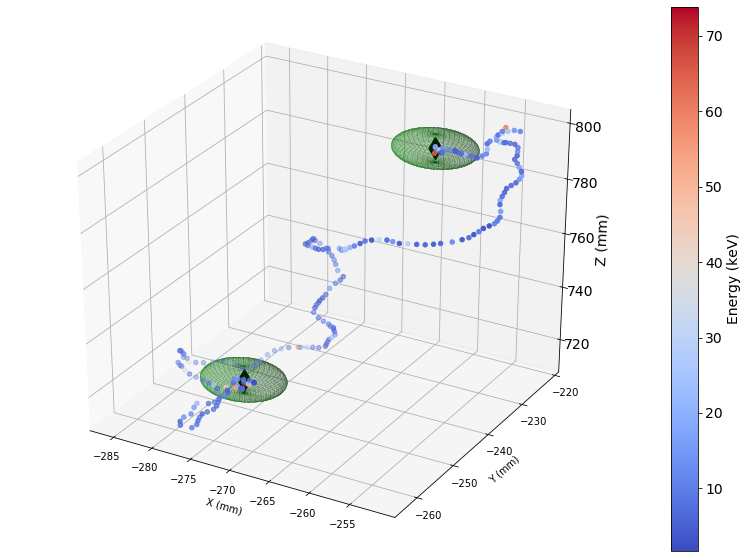

In [385]:
gt = GTrack(gtrack, event_id=0)
plot_gtrack(gt,
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

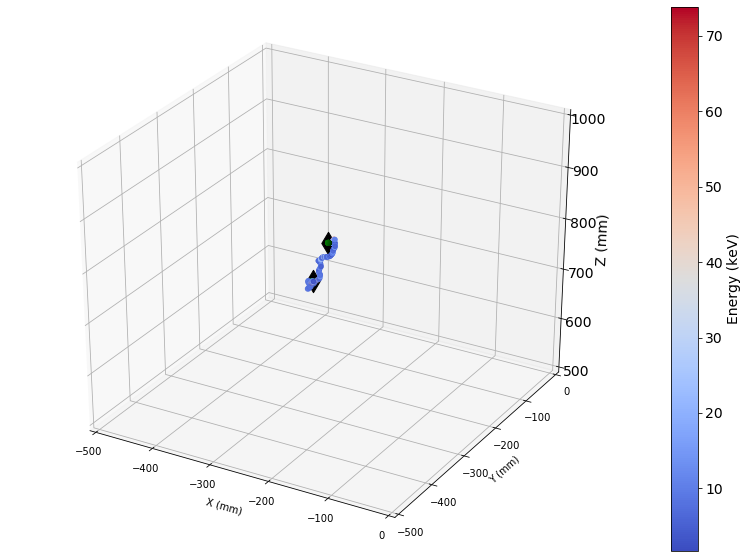

In [390]:
plot_gtrack(gt,
            rblob     = 5,
            autorange = False,
            weight    = 'energy',
            xrange    = (-500,0),
            yrange    = (-500,0),
            zrange    = (500,1000),
            figsize   = (14,10))

#### Show the dependence of number of voxels with blob radius

In [367]:
nvox1_rb2 = voxels_in_blob(gt, rb=2, extreme ='e1')

In [369]:
nvox1_rb2.df 

,x,y,z,energy,nhits
0,-272.914238,-256.264140,727.974154,0.009926,2.0
1,-273.520146,-256.513579,727.965844,0.015659,3.0
2,-272.379378,-255.719379,727.559607,0.010323,3.0
3,-274.046989,-256.375169,727.394648,0.011636,2.0
4,-271.924957,-255.618942,726.910645,0.001723,1.0
5,-273.879547,-257.022247,726.914001,0.007353,1.0
6,-271.979248,-255.420074,726.626831,0.003819,1.0
7,-273.323405,-257.244834,726.339589,0.015949,2.0


In [377]:
X = np.arange(1,10, 0.1)

In [378]:
nvox1 = [len(voxels_in_blob(gt, rb, extreme ='e1').df) for rb in X]

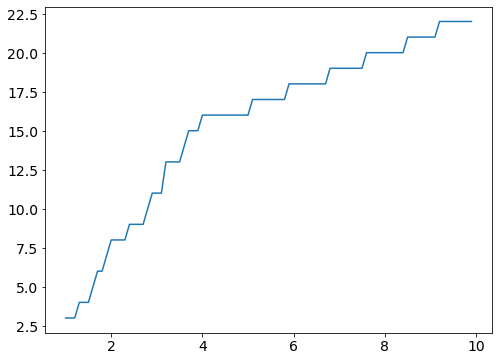

In [379]:
plt.plot(X, nvox1)

In [380]:
nvox2 = [len(voxels_in_blob(gt, rb, extreme ='e2').df) for rb in X]

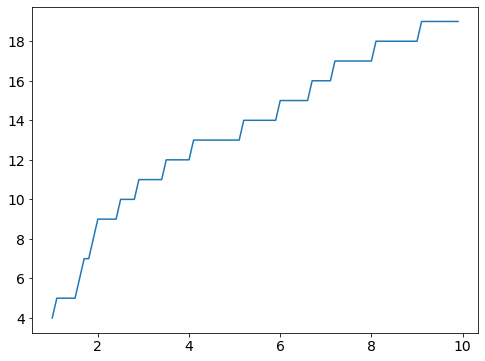

In [381]:
plt.plot(X, nvox2)

In [ ]:
def bb_stats(trs):
    

- The number of voxels increases rapidly until a radius of about 5 mm, then the slope is softer. 
- Thus, rb = 5 mm appears as a good choice

In [382]:
blob_energy(gt, rb = 5, extreme  ='e1')

290.0524924043566

In [383]:
blob_energy(gt, rb = 5, extreme  ='e2', unit=keV)

217.7133453078568

### The case of large voxels

In [391]:
vt5 = voxelize_hits(mchits, bin_size = 5, baryc = True)

In [392]:
voxels = get_voxels_as_list(vt5)

In [393]:
minimum_d, inclusive_d = voxel_distances(voxels)

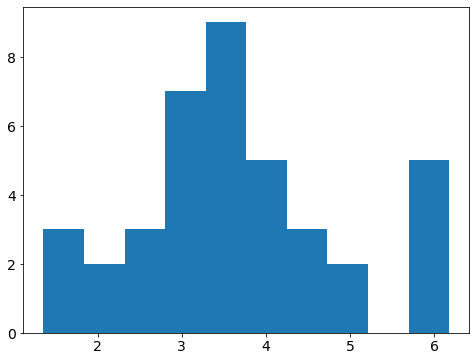

In [394]:
out = plt.hist(minimum_d)

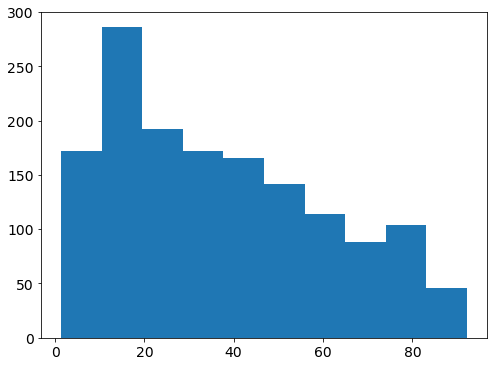

In [395]:
out = plt.hist(inclusive_d)

In [396]:
contiguity = 8
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 8 is 1


In [397]:
gtrack = gtracks[0]

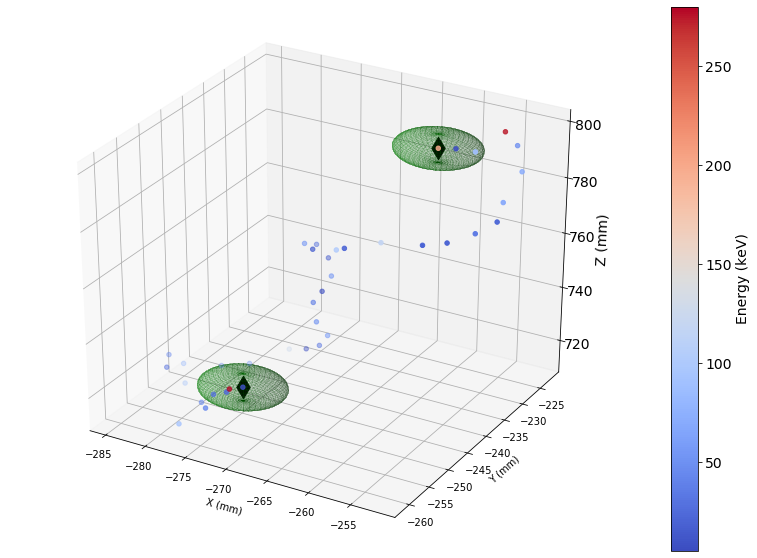

In [398]:
gt = GTrack(gtrack, event_id=0)
plot_gtrack(gt,
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

In [399]:
nvox1 = [len(voxels_in_blob(gt, rb, extreme ='e1').df) for rb in X]

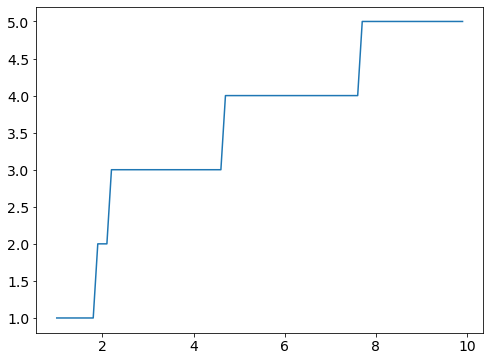

In [400]:
plt.plot(X, nvox1)

In [401]:
blob_energy(gt, rb = 5, extreme  ='e1')

343.6844479292631

In [402]:
blob_energy(gt, rb = 5, extreme  ='e2')

292.8846711292863